In [2]:
pip install opencv-python dlib scipy paho-mqtt matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


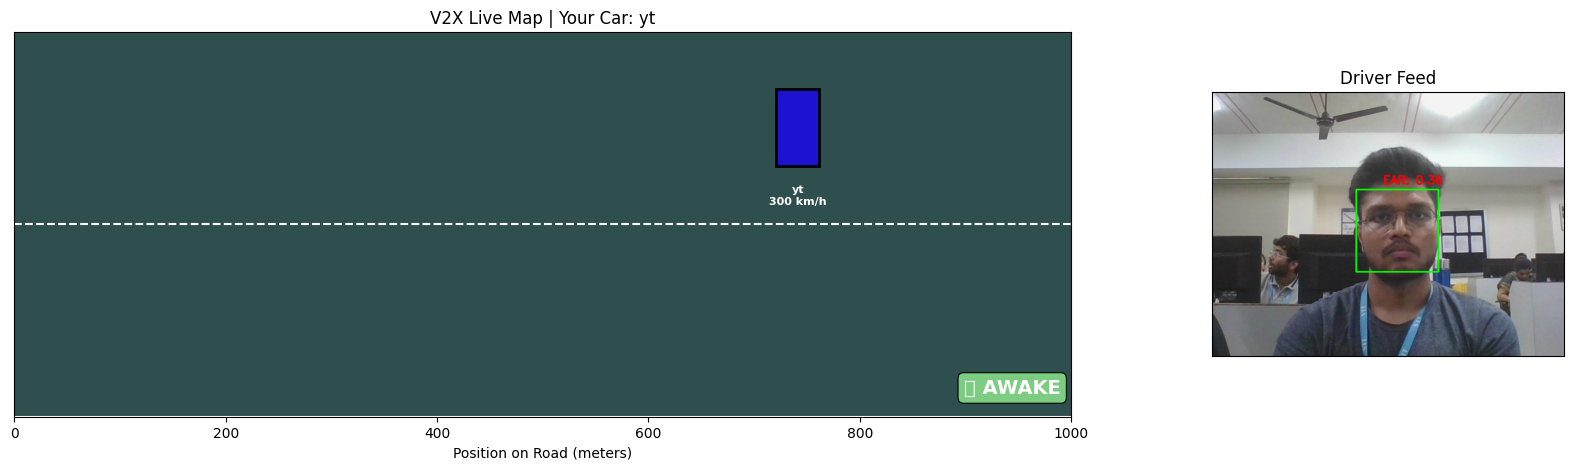

In [ ]:
# ==========================
# 1. IMPORTS and SETUP
# ==========================
import cv2
import dlib
import paho.mqtt.client as mqtt
import time
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output
from scipy.spatial import distance as dist
import numpy as np
import os

# ==========================
# 2. CONFIGURATION
# ==========================
# --- Simulation Parameters ---
BROKER = "broker.emqx.io"
PORT = 1883
TOPIC = "v2x/vehicles/simulation_map_v6"
LANE_LENGTH = 1000
CAR_WIDTH = 40
MIN_FOLLOW_DISTANCE = 50
NUM_LANES = 2
LANE_Y_POSITIONS = [1, 3]

# --- Drowsiness Detection Parameters (TUNABLE) ---
EAR_THRESH = 0.25  # !! TUNE THIS VALUE !!
EAR_CONSEC_FRAMES = 48
DLIB_MODEL_PATH = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(DLIB_MODEL_PATH):
    raise FileNotFoundError(f"Error: Dlib model file not found. Please download '{DLIB_MODEL_PATH}' and place it in the same folder.")

# --- Vehicle State Machine Modes ---
MODE_MANUAL_DRIVING = "MANUAL_DRIVING"
MODE_AUTONOMOUS_TAKEOVER = "AUTONOMOUS_TAKEOVER"
MODE_CHANGING_LANE = "CHANGING_LANE"
MODE_BRAKING = "BRAKING"
MODE_EMERGENCY_STOP = "EMERGENCY_STOP"

# ==========================
# 3. HELPER FUNCTION: EYE ASPECT RATIO
# ==========================
def calculate_ear(eye):
    A = dist.euclidean(eye[1], eye[5]); B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3]); ear = (A + B) / (2.0 * C)
    return ear

# ==========================
# 4. INITIALIZATION
# ==========================
VEHICLE_ID = input("Enter a UNIQUE Vehicle ID (e.g., CAR1, CAR2): ")
while True:
    try:
        speed_kmh = int(input(f"Enter target speed for {VEHICLE_ID} in km/h (e.g., 90): "))
        if speed_kmh > 0: TARGET_SPEED_MS = speed_kmh / 3.6; break
        else: print("❌ Speed must be positive.")
    except ValueError: print("❌ Invalid input. Please enter a number.")

vehicle_state = {
    "id": VEHICLE_ID, "position": random.randint(0, 100), "speed": TARGET_SPEED_MS,
    "target_speed": TARGET_SPEED_MS, "color": f"#{random.randint(0, 0xFFFFFF):06x}",
    "lane": 1, "mode": MODE_MANUAL_DRIVING, "status": "OK",
    "y_pos_visual": LANE_Y_POSITIONS[1]
}
all_vehicles = {}; detector = dlib.get_frontal_face_detector(); predictor = dlib.shape_predictor(DLIB_MODEL_PATH)
(lStart, lEnd) = (42, 48); (rStart, rEnd) = (36, 42); frame_counter = 0

# --- MQTT Setup ---
def on_connect(client, userdata, flags, rc): print(f"[{VEHICLE_ID}] Connected to MQTT Broker!"); client.subscribe(TOPIC)
def on_message(client, userdata, msg):
    global all_vehicles
    try:
        sender_id, pos, speed, color, lane, status = msg.payload.decode().split(",")
        if sender_id != VEHICLE_ID: all_vehicles[sender_id] = {"position": float(pos), "speed": float(speed), "color": color, "lane": int(lane), "status": status, "last_updated": time.time()}
    except Exception: pass
client = mqtt.Client(client_id=f"{VEHICLE_ID}-{random.randint(100,999)}", protocol=mqtt.MQTTv311)
client.on_connect = on_connect; client.on_message = on_message; client.connect(BROKER, PORT, 60); client.loop_start()

# ==========================
# 5. VISUALIZATION DASHBOARD
# ==========================
def update_dashboard(vehicles, frame, vehicle_main_state):
    clear_output(wait=True)
    fig, (ax_map, ax_camera) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [3, 1]})
    
    # --- Subplot 1: V2X Map ---
    ax_map.set_facecolor('darkslategray')
    ax_map.set_xlim(0, LANE_LENGTH); ax_map.set_ylim(0, 4); ax_map.set_yticks([])
    ax_map.set_xlabel("Position on Road (meters)"); ax_map.set_title(f"V2X Live Map | Your Car: {vehicle_main_state['id']}")
    ax_map.axhline(y=0, color='white'); ax_map.axhline(y=2, color='white', linestyle='--'); ax_map.axhline(y=4, color='white')

    for vehicle_id, data in vehicles.items():
        pos, lane = data.get("position", 0), data.get("lane", 0)
        color = '#FFFF00' if data.get("status") == "DROWSY" else data.get("color", "gray")
        y_pos = data.get('y_pos_visual', LANE_Y_POSITIONS[lane])
        car_rect = patches.Rectangle((pos - CAR_WIDTH / 2, y_pos - 0.4), CAR_WIDTH, 0.8, linewidth=2, edgecolor='black', facecolor=color)
        ax_map.add_patch(car_rect)
        speed_kmh = data.get("speed", 0) * 3.6
        ax_map.text(pos, y_pos - 0.7, f"{vehicle_id}\n{speed_kmh:.0f} km/h", color='white', ha='center', va='center', fontsize=8, fontweight='bold')

    # --- Drowsiness Status Indicator ---
    status = vehicle_main_state['status']
    if status == 'DROWSY': status_text, status_color = "⚠️ DROWSY", "red"
    else: status_text, status_color = "✅ AWAKE", "lightgreen"
    ax_map.text(0.99, 0.05, status_text, transform=ax_map.transAxes, fontsize=14, color='white', fontweight='bold',
                verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor=status_color, alpha=0.8))

    # --- Subplot 2: Live Camera Feed ---
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax_camera.imshow(frame_rgb)
    ax_camera.set_title("Driver Feed"); ax_camera.set_xticks([]); ax_camera.set_yticks([])
    
    plt.show()

# ==========================
# 6. MAIN SIMULATION & CV LOOP
# ==========================
print("INFO: Starting video stream...")
cap = cv2.VideoCapture(0)
time.sleep(1.0)
last_frame_time = time.time()
if not cap.isOpened(): raise IOError("Cannot open webcam. Check if it's connected or used by another application.")

try:
    while True:
        # --- A. Grab and process camera frame ---
        ret, frame = cap.read()
        if not ret: break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)
        drowsy_event = False

        for rect in rects:
            # --- NEW: Draw a green box around the detected face ---
            (x, y, w, h) = (rect.left(), rect.top(), rect.right() - rect.left(), rect.bottom() - rect.top())
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            shape = predictor(gray, rect)
            shape = np.array([[p.x, p.y] for p in shape.parts()])
            leftEye, rightEye = shape[lStart:lEnd], shape[rStart:rEnd]
            ear = (calculate_ear(leftEye) + calculate_ear(rightEye)) / 2.0

            if ear < EAR_THRESH:
                frame_counter += 1
                if frame_counter >= EAR_CONSEC_FRAMES:
                    drowsy_event = True
                    cv2.putText(frame, "DROWSINESS DETECTED", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            else:
                frame_counter = 0

            # --- NEW: Display the live EAR value on the camera feed for tuning ---
            cv2.putText(frame, f"EAR: {ear:.2f}", (x + w - 100, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # --- B. Update Simulation State ---
        current_time = time.time()
        delta_time = current_time - last_frame_time
        if delta_time < 0.03: continue
        last_frame_time = current_time
        
        stale_vehicles = [vid for vid, data in all_vehicles.items() if current_time - data.get("last_updated", 0) > 5]
        for vid in stale_vehicles: all_vehicles.pop(vid, None)

        # --- C. VEHICLE STATE MACHINE ---
        if drowsy_event and vehicle_state["mode"] == MODE_MANUAL_DRIVING:
            vehicle_state["mode"] = MODE_AUTONOMOUS_TAKEOVER; vehicle_state["status"] = "DROWSY"
            print("ALERT: Drowsiness detected! Autonomous safe-stop initiated.")
        
        if vehicle_state["mode"] == MODE_MANUAL_DRIVING:
            my_pos, my_lane = vehicle_state["position"], vehicle_state["lane"]
            leader, min_forward_dist = None, float('inf')
            for other_id, other_data in all_vehicles.items():
                if other_id == VEHICLE_ID or other_data.get("lane") != my_lane: continue
                forward_dist = (other_data['position'] - my_pos + LANE_LENGTH) % LANE_LENGTH
                if forward_dist < min_forward_dist: min_forward_dist, leader = forward_dist, other_data
            current_speed = vehicle_state["target_speed"]
            if leader and min_forward_dist < (MIN_FOLLOW_DISTANCE * 1.5):
                current_speed = min(current_speed, leader.get("speed", current_speed))
            distance_to_move = current_speed * delta_time
            if leader:
                max_safe_travel_dist = min_forward_dist - MIN_FOLLOW_DISTANCE
                distance_to_move = min(distance_to_move, max(0, max_safe_travel_dist))
            vehicle_state["position"] = (my_pos + distance_to_move) % LANE_LENGTH
            vehicle_state["speed"] = distance_to_move / delta_time if delta_time > 0 else 0
        
        elif vehicle_state["mode"] == MODE_AUTONOMOUS_TAKEOVER:
            vehicle_state["target_lane"] = 0; vehicle_state["mode"] = MODE_CHANGING_LANE
        
        elif vehicle_state["mode"] == MODE_CHANGING_LANE:
            target_y = LANE_Y_POSITIONS[vehicle_state["target_lane"]]
            vehicle_state["y_pos_visual"] += (target_y - vehicle_state["y_pos_visual"]) * 0.05
            if abs(target_y - vehicle_state["y_pos_visual"]) < 0.1:
                vehicle_state["lane"] = vehicle_state["target_lane"]
                vehicle_state["y_pos_visual"] = target_y; vehicle_state["mode"] = MODE_BRAKING
        
        elif vehicle_state["mode"] == MODE_BRAKING:
            vehicle_state["speed"] -= 2.5 * delta_time; vehicle_state["speed"] = max(0, vehicle_state["speed"])
            distance_to_move = vehicle_state["speed"] * delta_time
            vehicle_state["position"] = (vehicle_state["position"] + distance_to_move) % LANE_LENGTH
            if vehicle_state["speed"] == 0: vehicle_state["mode"] = MODE_EMERGENCY_STOP
        
        # --- D. Update and Broadcast ---
        all_vehicles[VEHICLE_ID] = vehicle_state
        message = (f"{VEHICLE_ID},{vehicle_state['position']:.2f},{vehicle_state['speed']:.2f},"
                   f"{vehicle_state['color']},{vehicle_state['lane']},{vehicle_state['status']}")
        client.publish(TOPIC, message)
        
        # --- E. Update Visualization Dashboard ---
        update_dashboard(all_vehicles, frame, vehicle_state)
        

except KeyboardInterrupt:
    print("\nStopping loop manually.")
finally:
    # --- F. Cleanup ---
    print("INFO: Stopping simulation and cleaning up...")
    cap.release()
    cv2.destroyAllWindows()
    client.loop_stop()
    client.disconnect()